Os seguintes scripts são uma versão Python do curso de Machine Learning do professor Andrew Ng da universidade de Stanford leccionado na plataforma Coursera.

**Nota: Todos os dados e estrutura do exercício pertencem à Universidade de Stanford**

**Ressalva:** Os scripts não estão implementados de forma modular para todas as funções serem consultadas no mesmo Jupyter Notebook - ao contrário da implementação Octave.

# Exercício 1 - Clusterização K-Means

In [1]:
# Importar o numpy para lidar com matrizes e vectores
import numpy as np
# Importar o pandas para ler alguns ficheiros
import pandas as pd
# Importar o matplotlib como ferramenta gráfica
import matplotlib.pyplot as plt

# Importar o módulo para tratar imagens
from PIL import Image

# Importar o módulo math 
import math 

# Importar a função de optimização do scipy
from scipy import optimize, io
from scipy.ndimage import rotate

# Matplotlib notebook property
%matplotlib inline

Um dos problemas com que nos deparamos, muitas vezes, em algoritmos de machine learning é o problema da redução da dimensionalidade. Seja para criarmos grupos homógeneos de observações (agrupamento vertical) ou para tentarmos reduzir a dimensionalidade das nossas colunas (agrupamento horizontal), existem diversas técnicas que nos ajudam a compreender melhor como os nossos dados se relacionam entre eles.

**Vamos começar por olhar para o algoritmo k-means que agrupa observações semelhantes em clusters com base na proximidade das suas variáveis:**

In [30]:
# Ler o dataset
X = io.loadmat('ex7data2.mat')['X']

In [31]:
# Inicializar os centróides
K = 3 

centroides_iniciais = np.array([[3,3],[6,2],[8,5]])

Acima, definimos três centróides iniciais - na próxima função vamos assignar cada uma das nossas observações a um destes centróides. Uma das grandes limitações do algoritmo k-means é que o número de clusters a serem criados é dado através de um hiper-parâmetro.

Para medir a distância das observações aos centróides, vamos usar a distância euclideana:

In [32]:
def encontrarCentroidesMaisProximos(
    X: np.array,
    centroides: np.array
) -> np.array:
    '''
    Assignar cada registo da matriz
    X ao centróide mais próximo dos pontos
    centróides usando a distância euclideana.
    
    Args:
        X(np.array): Observações originais.
        centroids(np.array): Centróides iniciais
        de cada cluster.
    
    Returns:
        idx(np.array): Vector com o centróide
        assignado a cada umas observações. 
    '''
    
    K = centroides.shape[0]
    
    idx = np.zeros([X.shape[0],1])
    
    obs = X.shape[0]
    
    for i in range(obs):
        
        distancia_eucl = (X[i]-centroides)**2
        centroide_mais_proximo = distancia_eucl.sum(axis=1).argmin()
        idx[i] = centroide_mais_proximo+1
    
    return idx

In [33]:
idx = encontrarCentroidesMaisProximos(X, centroides_iniciais)

In [34]:
print("As primeiras observações estão mais próximas dos centróides {}".format(idx[0:3].flatten()))

As primeiras observações estão mais próximas dos centróides [1. 3. 2.]


Baseada na distância euclideana entre a observação e os centróides:
<br>
- A primeira observação está mais perto do primeiro centróide.
<br>
- A segunda observação está mais do terceiro centróide.
<br>
- A terceira observação está mais perto do segundo centróide.
<br>
<br>
Podemos confirmar isto ao vermos as observações e os centróides num gráfico:

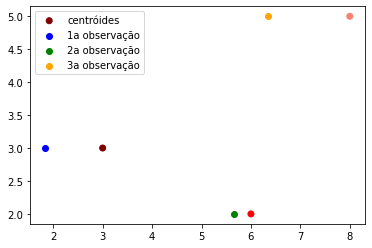

In [35]:
plt.scatter(centroides_iniciais[:,0],centroides_iniciais[:,1], color=['maroon','red','salmon'])
plt.scatter(X[0,0],centroides_iniciais[0,1], color='blue')
plt.scatter(X[1,0],centroides_iniciais[1,1], color='green')
plt.scatter(X[2,0],centroides_iniciais[2,1], color='orange')
plt.legend(['centróides','1a observação','2a observação','3a observação'])

Os centróides estão desenhados numa escala de vermelhos. Vermelho escuro é o primeiro centróide e vermelho mais claro é o terceiro centróide.
<br>
Podemos confirmar que as distâncias que calculámos estão de facto correctas.
<br>
**Abaixo vamos olhar para uma quarta observação, conseguem adivinhar a que cluster irá pertencer esta 4a observação?**

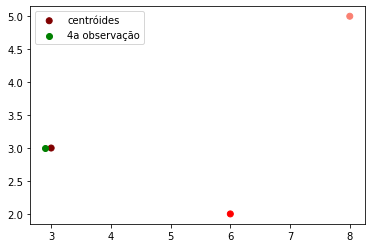

In [36]:
plt.scatter(centroides_iniciais[:,0],centroides_iniciais[:,1], color=['maroon','red','salmon'])
plt.scatter(X[3,0],centroides_iniciais[0,1], color='green')
plt.legend(['centróides','4a observação'])

In [37]:
print("A quarta observação pertence ao cluster {}".format(idx[4].flatten()))

A quarta observação pertence ao cluster [1.]


Agora, podemos recalcular a média de cada centróide, actualizando o seu valor.
<br>
As médias dos novos centróides serão calculadas com a seguinte fórmula:

<img src="assets/ClusterMeanFormula.JPG">

In [38]:
def calcularCentroides(
    X: np.array, 
    idx: np.array,
    K: int
)-> np.array:
    '''
    Calcula a nova média dos centróides 
    com base nas observações que foram agregadas
    a esse centróide.
    
    Args:
        X(np.array): Observações originais.
        idx(np.array): Vector com os clusters
        a que pertencem cada observação.
        K(int): Número de clusters.
        
    Returns:
        centroides(np.array): Novos centroids
        recalculados com base na assignação
        das observações de X.
    '''
    
    m,n = X.shape
    centroides = np.zeros([K, n])
    
    for i in range(1,K+1):
        centroides[i-1,:] = X[np.array(idx==i).flatten(),:].mean(axis=0)
    
    return centroides

In [39]:
centroides = calcularCentroides(X, idx, K)

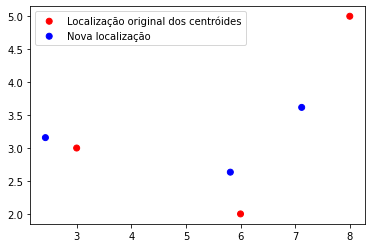

In [40]:
plt.scatter(centroides_iniciais[:,0],centroides_iniciais[:,1], color=['red','red','red'])
plt.scatter(centroides[:,0],centroides[:,1], color=['blue','blue','blue'])
plt.legend(['Localização original dos centróides','Nova localização'])

Como podemos ver, os centróides sofreram uma actualização. O objectivo do algoritmo K-means é iterar e recalcular estas médias até conseguirmos minimar as distâncias entre qualquer ponto e o centróide mais próximo. 

**Vamos, de seguida, implementar o algoritmo k-means:**

In [41]:
# Número de centróides
k = 3 

# Máximo iterações
max_iters = 10

# Centróides iniciais
centroides_iniciais = np.array([[3, 3],[6, 2],[8, 5]])

In [45]:
def correrkMeans(
    X: np.array,
    centroides_iniciais: np.array,
    max_iters: int
):
    '''
    Corre o algoritmo K-means, recalculando
    as médias dos centróides até serem atingidas as 
    iteracções.
    
    Args:
        X(np.array): Observações originais.
        initial_centroids(np.array): Valores 
        iniciais dos centróides.
        max_iters(int): Número de iteracções
        a serem atingidas.

    Returns:
        centroids(np.array): Novos valores
        dos centróides optimizados.
        idx(np.array): Vector com cada cluster
        assignado às observações.
    '''
    
    # Obter as dimensões dos dados
    m, n = X.shape
    
    # Calcular centróides iniciais
    centroides = centroides_iniciais
    
    # Criar placeholder para o vector de clusters
    idx = np.zeros([m,1])
    
    # Para cada iteração, encontrar os centróides mais próximos
    # e recalcular as médias dos centróides.
    
    for i in range(1, max_iters):
        
        idx = encontrarCentroidesMaisProximos(X, centroides)
        centroides = calcularCentroides(X, idx, K)
        
    return centroides, idx

In [46]:
centroides, idx = correrkMeans(X, centroides_iniciais, max_iters)

In [48]:
print("Depois de 10 iterações, os novos centróides são\n {}".format(centroides))

Depois de 10 iterações, os novos centróides são
 [[1.95399466 5.02557006]
 [3.04367119 1.01541041]
 [6.03366736 3.00052511]]


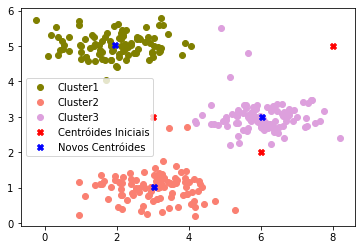

In [50]:
plt.scatter(X[np.array(idx==1).flatten(),:][:, 0],
           X[np.array(idx==1).flatten(),:][:, 1], color='olive')
plt.scatter(X[np.array(idx==2).flatten(),:][:, 0],
           X[np.array(idx==2).flatten(),:][:, 1], color='salmon')
plt.scatter(X[np.array(idx==3).flatten(),:][:, 0],
           X[np.array(idx==3).flatten(),:][:, 1], color='plum')
plt.scatter(centroides_iniciais[:,0],centroides_iniciais[:,1], color="red", marker='X')
plt.scatter(centroides[:,0],centroides[:,1], color="blue", marker='X')
plt.legend(['Cluster1','Cluster2','Cluster3','Centróides Iniciais','Novos Centróides'])

Podemos verificar graficamente o poder do algoritmo k-means acima. Com apenas 10 iterações, fomos capazes de nos aproximar ao centro de cada uma das nuvens de pontos dos dados acima, criando três grupos de observações homogéneas. Na "vida real" é raro encontrar um problema que tenha as observações separadas de forma tão geométrica mas, ainda assim, o k-means consegue ajudar a perceber a homogeneidade nos dados de forma bastante satisfatória.

Vamos ver como o algoritmo k-means pode ajudar a comprimir uma imagem:

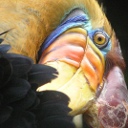

In [51]:
image = Image.open(r"bird_small.png")
image

In [52]:
A = np.asarray(image)

In [53]:
A = A/255

In [54]:
# Obter o tamanho da imagem
tamanho_imagem = A.shape

In [55]:
# Redimensionar a nossa imagem para uma dimensão RGB
X = A.reshape(A.shape[0]*A.shape[1],A.shape[2])

In [56]:
# Seleccionar hiperparâmetros do k-means
K = 16
max_iters = 10

**Para diminuir o risco de uma má convergência do algoritmo k-means, é boa prática inicializar os centróides de forma completamente aleatória.**

In [57]:
def kMeansInitCentroides(
    X: np.array,
    K: int
):
    '''
    Initicializar os centróides com base
    em observações aleatórias da matriz X-
    
    Args:
        X(np.array): Vector com cada uma das
        observações originais.
        K(int): Número dos centróides.
        
    Returns:
        centroides(np.array): Média dos centróides
        com as observações seleccionadas aleatoriamente.
    
    '''
    # Selecionar 16 exemplos da matriz X 
    # para serem usados como média dos
    # centróides iniciais
    indexes_aleatorios = np.random.uniform(
        low=0, 
        high=X.shape[0], 
        size=(K,)
    ).astype(int)
    
    centroides = X[indexes_aleatorios,:]
    
    return centroides

In [58]:
centroides_iniciais = kMeansInitCentroides(X, K);

In [59]:
# Correr o algoritmo kmeans
centroides, idx = correrkMeans(X, centroides_iniciais, max_iters)

**Agora que corremos o algoritmo, o que irá acontecer à nossa imagem se utilizarmos o valor de cada cluster em vez das observações originais?**

In [60]:
idx = encontrarCentroidesMaisProximos(X, centroides)

In [61]:
# Encontrar os novos valores com base nos centroides
X_recup = centroides[idx.astype(int).flatten()-1,:]

In [63]:
# Redimensionar a imagem para o tamanho original
X_recup = X_recup.reshape(tamanho_imagem)

In [64]:
imagens = {'imagem': image,
      'compressed_imagem': X_recup}

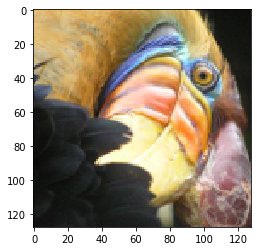

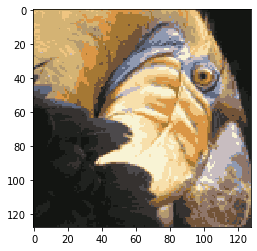

In [65]:
for img in imagens:
    plt.figure()
    plt.imshow(imagens[img], interpolation='nearest')

**Comprimimos a imagem com sucesso usando o algoritmo k-means.** 
<br>
<br>
Reduzir a dimensionalidade dos dados pode ter bastantes vantagens em muitos algoritmos de aprendizagem (pode, por exemplo, ajudar a reduzir o overfitting) além de trazer alguns benefícios em termos de cálculos computacionais como, por exemplo, reduzir o tamanho usado em disco para os dados. 